**Description of the dataset via Kaggle**

One of the leading retail stores in the US, Walmart, would like to predict the sales and demand accurately. There are certain events and holidays which impact sales on each day. There are sales data available for 45 stores of Walmart. The business is facing a challenge due to unforeseen demands and runs out of stock some times, due to the inappropriate machine learning algorithm. An ideal ML algorithm will predict demand accurately and ingest factors like economic conditions including CPI, Unemployment Index, etc.

Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of all, which are the Super Bowl, Labour Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data. Historical sales data for 45 Walmart stores located in different regions are available.

**Aim of the project**

The goal of the project is to create predictions for weekend sales for each of the 45 Walmart stores over a period of 17 weeks. At the outset, I want to acknowledge that such a long prediction period may not be entirely realistic. In this project, I am solely interested in exploring time series forecasting techniques other than the ARIMA "family."  
The project can be divided into two parts: models where the model learns solely from a single time series (local models) such as Holt-Winters, Theta, Prophet, and models where global models are used (Random Forest, NBeats), where the model learns from the values of ALL time series. Primarily for store number 1, I aim to demonstrate what the prediction looks like over time compared to reality.

## 1. Import libraries

In [1]:
!pip install darts
!pip install missingno
!pip install chart_studio
!pip install cufflinks
# Data analysis
import numpy as np
import pandas as pd
import darts
import time
import missingno as msno

# Visualisation
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import cufflinks as cf
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

# Modelling
# from src.utils.ts_utils import forecast_bias
from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveMean,
    NaiveDrift,
    ExponentialSmoothing,
    AutoARIMA,
    ARIMA,
    Theta,
    FFT
)
from darts.metrics import mase, mse, mae, ope
from statsmodels.tsa.seasonal import seasonal_decompose
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler

# Other
import os
from darts import concatenate
from tqdm.autonotebook import tqdm
tqdm.pandas()


import plotly.io as pio
pio.renderers.default = "colab"
from darts import TimeSeries
from sklearn.preprocessing import LabelEncoder

# model interpretability
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 702.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('drive/MyDrive/walmart_time_series')

## 2. Load data

In [4]:
walmart = pd.read_csv('Walmart.csv', parse_dates=False)

In [5]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
walmart['Date'] = pd.to_datetime(walmart['Date'], format='%d-%m-%Y')

In [8]:
check_dates = walmart.groupby("Store")['Date'].agg(['min', 'max', 'count'])
check_dates['days_between'] = ((check_dates['max'] - check_dates['min']).dt.days / 7) + 1
display(check_dates)

,min,max,count,days_between
Store,,,,
1,2010-02-05,2012-10-26,143,143.0
2,2010-02-05,2012-10-26,143,143.0
3,2010-02-05,2012-10-26,143,143.0
4,2010-02-05,2012-10-26,143,143.0
5,2010-02-05,2012-10-26,143,143.0
6,2010-02-05,2012-10-26,143,143.0
7,2010-02-05,2012-10-26,143,143.0
8,2010-02-05,2012-10-26,143,143.0
9,2010-02-05,2012-10-26,143,143.0


It doesn't seem that there's a gap in the dates in the data, so there's no need to clean the data based on date criteria.

## 3. Exploratory Data Analysis

The chart below shows that for most stores, there are certain seasonal events (such as Christmas holidays) where the total weekly turnover is much higher compared to other periods. Perhaps a similar phenomenon occurs during Easter holidays, although it is not as pronounced as we observe during the Christmas holidays.

In [9]:
px.line(walmart, x='Date', y='Weekly_Sales',  color='Store', labels={'Weekly_Sales':'Sales'})

In [10]:
walmart['year'] = [d.strftime('%Y') for d in walmart['Date']]
walmart['month'] = [d.strftime('%b') for d in walmart['Date']]
walmart['weekday'] = [d.strftime('%A') for d in walmart['Date']]

In [11]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

for col in ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
    plot_df = walmart.groupby(["year", "month"])[col].mean().reset_index()
    plot_df['month'] = pd.Categorical(plot_df['month'], categories=months, ordered=True)
    plot_df.sort_values(["year", "month"], inplace=True, ascending=False)
    fig = px.line(plot_df, x="month", y=col, color="year", line_dash="year", title=f"{col} divided into years and months")
    fig.update_xaxes(categoryorder='array', categoryarray=months)
    fig.show()

In [12]:
sorted(np.unique(walmart[walmart.Holiday_Flag == 1]['Date']))

[numpy.datetime64('2010-02-12T00:00:00.000000000'),
 numpy.datetime64('2010-09-10T00:00:00.000000000'),
 numpy.datetime64('2010-11-26T00:00:00.000000000'),
 numpy.datetime64('2010-12-31T00:00:00.000000000'),
 numpy.datetime64('2011-02-11T00:00:00.000000000'),
 numpy.datetime64('2011-09-09T00:00:00.000000000'),
 numpy.datetime64('2011-11-25T00:00:00.000000000'),
 numpy.datetime64('2011-12-30T00:00:00.000000000'),
 numpy.datetime64('2012-02-10T00:00:00.000000000'),
 numpy.datetime64('2012-09-07T00:00:00.000000000')]

The description attached to the dataset stated that there should be four holidays. It was decided to check if their dates align with reality. No inconsistencies were detected.

<Figure size 800x400 with 0 Axes>

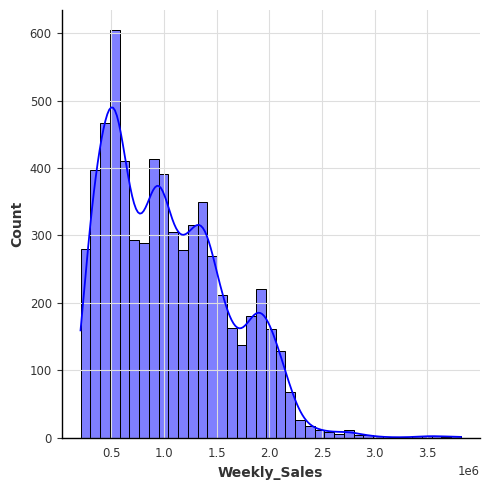

In [13]:
plt.figure(figsize=[8,4])
ax = sns.displot(walmart.Weekly_Sales, color='blue', kde=True)
plt.show()

Let's roughly look at one store for which we will show the Weekly Sales over time along with their 7-day and 30-day moving averages.

In [14]:
def store_plots(store_number):

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=walmart[walmart.Store==store_number].Date, y=walmart[walmart.Store==store_number].Weekly_Sales, mode='lines', name=f'Weekly Sales Store {store_number}'))
    fig.add_trace(go.Scatter(x=walmart[walmart.Store==store_number].Date, y=walmart[walmart.Store==store_number].Weekly_Sales.rolling(7).mean(), mode='lines', name=f'MA7 Weekly Sales Store {store_number}'))
    fig.add_trace(go.Scatter(x=walmart[walmart.Store==store_number].Date, y=walmart[walmart.Store==store_number].Weekly_Sales.rolling(30).mean(), mode='lines', name=f'MA30 Weekly Sales Store {store_number}'))

    fig.show()

In [15]:
for store in [1, 33]:
    store_plots(store)

Indeed, comparing the differences in sales charts between Store 1 and Store 33 can shed light on many factors influencing the disparities in sales between them. Here are several possible factors that may contribute to these differences:

Store Size: Store 1 may be larger and more extensive than Store 33, leading to higher sales volume.

Location: Store 1 may be situated in a better location with higher foot traffic or in an area with higher per capita income, translating to higher turnover.

Competition: Store 1 may face less competition in the vicinity, making it the preferred choice for customers, whereas Store 33 might be surrounded by a greater number of competing stores, decreasing its sales.

Product Assortment: Store 1 may offer a wider range of products or specialize in items that are more popular in that location, attracting customers.

Marketing and Promotions: Store 1 may conduct a more aggressive marketing campaign or offer better promotions, attracting customers and increasing sales.

In the case of global models, stores such as Store 33, which deviate from the characteristics of the other stores, may have a negative impact on the results.

### Decomposition

In [16]:
def decomposition(store_number):

    walmart_decompose = walmart[walmart.Store == store_number]["Weekly_Sales"].set_axis(walmart[walmart.Store == store_number]["Date"]).copy()
    walmart_decompose.head()

    res = seasonal_decompose(walmart_decompose, period=7)

    fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(16,12))
    fig.suptitle(f'Decomposition for store {store_number}', fontsize=16)
    res.trend.plot(ax=ax1)
    ax1.set_title('Trend')
    res.seasonal.plot(ax=ax2)
    ax2.set_title('Seasonality')
    res.resid.plot(ax=ax3)
    ax3.set_title('Residuals')
    plt.tight_layout()
    print("\n\n")

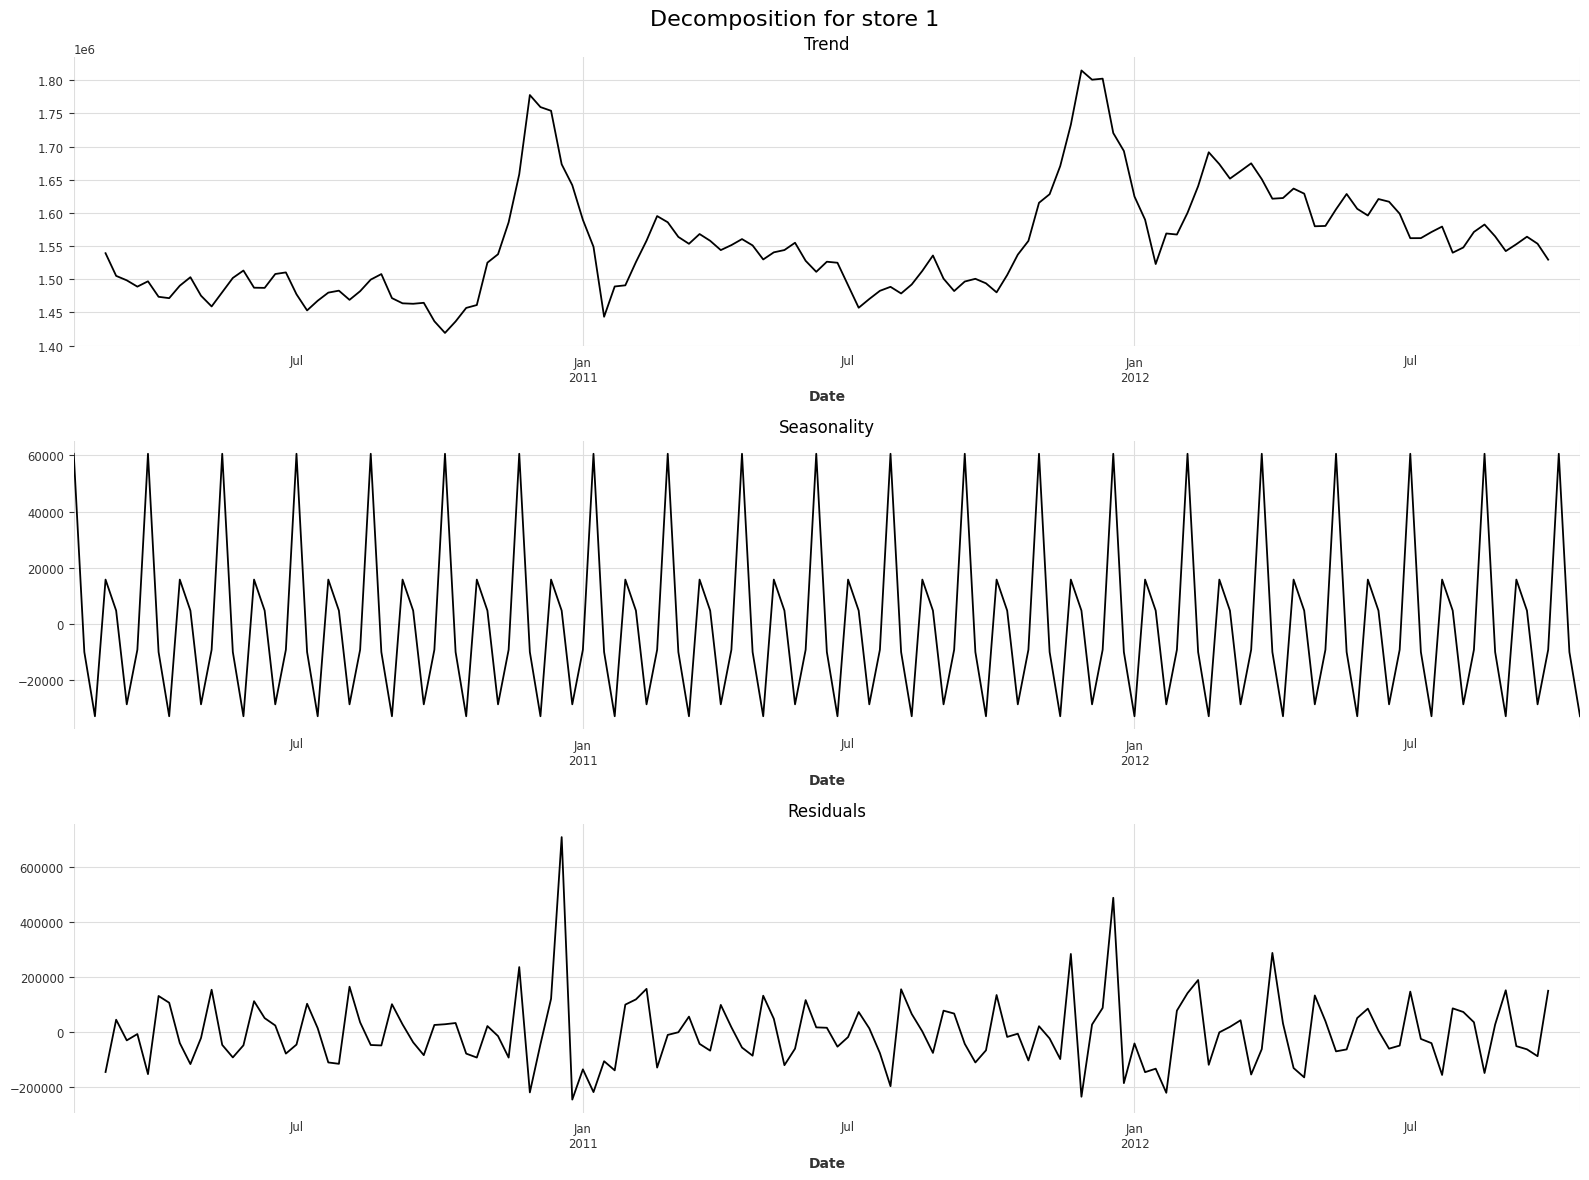

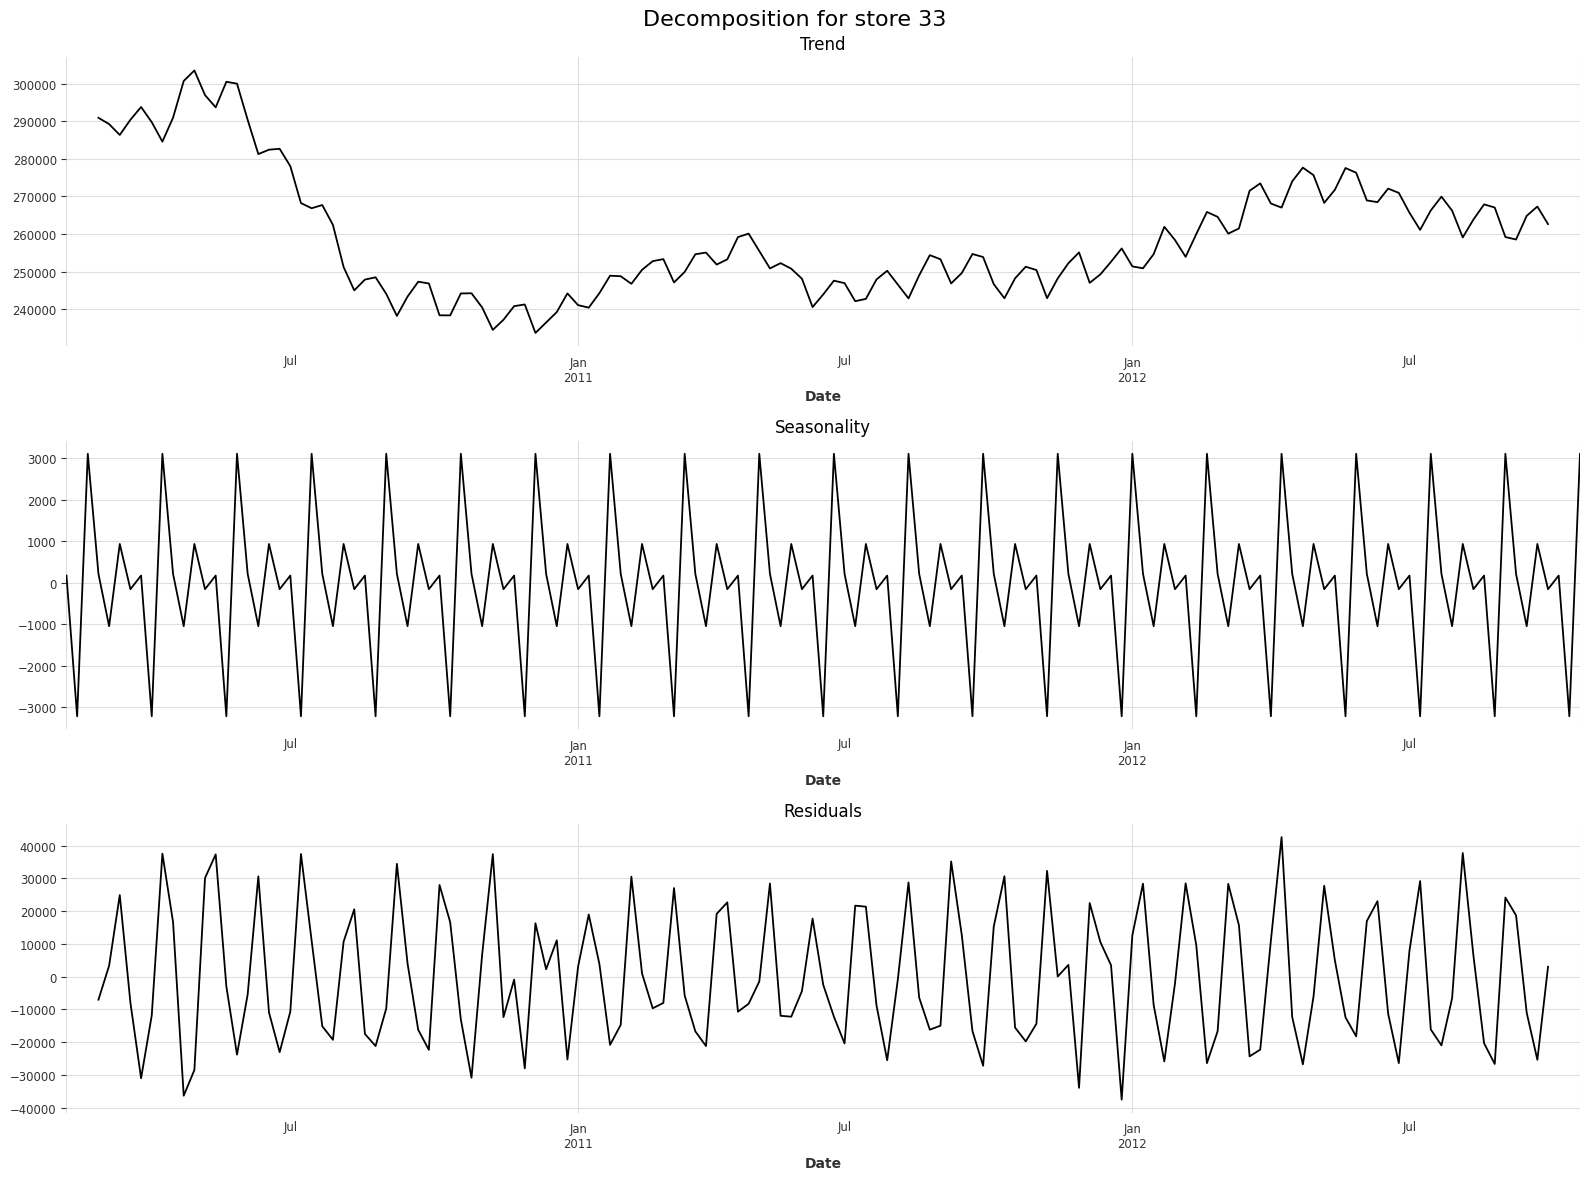

In [17]:
for store in [1, 33]:
    decomposition(store)

### Coefficient of Variation

The Coefficient of Variation (CoV) relies on the intuition that the more variability that you find in
a time series, the harder it is to predict it. And how do we measure variability in a random variable?
Standard deviation.
The lower the CoV the higher the forecastability because the lower is the dispersion around the mean.
There is no hard cutoff,
but a value of 0.49 is considered a rule of thumb to separate time series that are relatively easier to
forecast from the hard ones.
Disadvantages:
- It doesn’t consider seasonality. A sine or cosine wave will have a higher CoV than a horizontal
line, but we know both are equally predictable.
- It doesn’t consider the trend. A linear trend will make a series have a higher CoV, but we know
it is equally predictable like a horizontal line is.
- It doesn’t handle negative values in the time series. If you have negative values, it makes the
mean smaller, thereby inflating the CoV.

In [18]:
def calc_cov(x):
    cov = np.std(x) / np.mean(x)
    return cov

In [19]:
walmart["forecastability_COV"] = walmart.groupby('Store')['Weekly_Sales'].transform(calc_cov)

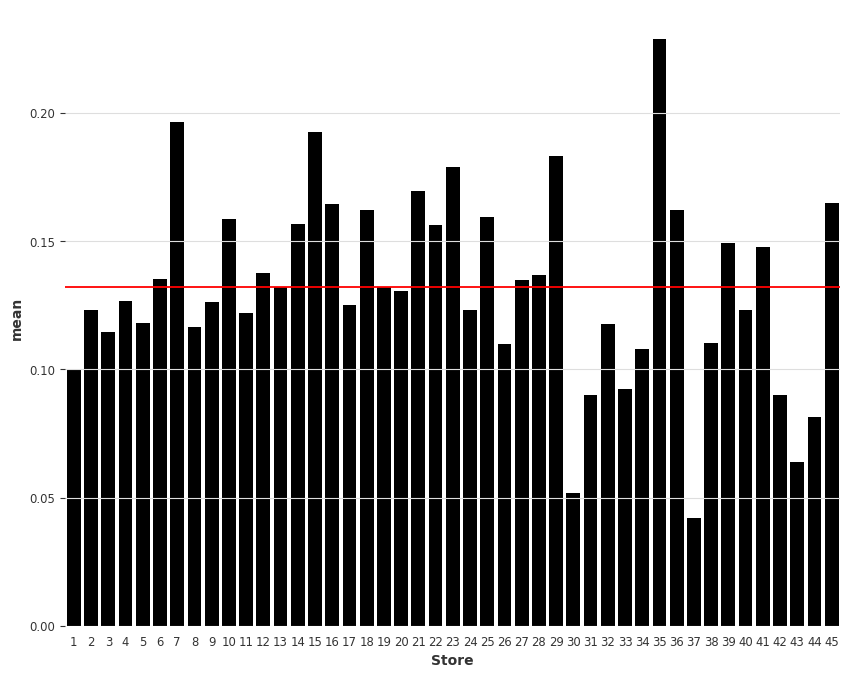

In [20]:
calc_cov_df = walmart.groupby('Store')['forecastability_COV'].agg({'mean'}).reset_index(drop=False)
plt.figure(figsize=(10,8))
ax = sns.barplot(x='Store', y='mean', data=calc_cov_df)
ax.axhline(y = np.mean(calc_cov_df['mean']), color='red')
plt.show()

## 4. Train, test, split

In [21]:
test_mask = (walmart.year=='2012') & (walmart.month.isin(['Jul', 'Aug', 'Sep', 'Oct']))

train = walmart[~test_mask]
test = walmart[test_mask]
print(f"# of Training samples: {len(train)} | # of Test samples: {len(test)}")
print(f"Max Date in Train: {train.Date.max()} | Min Date in Test: {test.Date.min()}")

# of Training samples: 5670 | # of Test samples: 765
Max Date in Train: 2012-06-29 00:00:00 | Min Date in Test: 2012-07-06 00:00:00


On the basis of one store, I want to create a simple baselines forecasts.

In [22]:
train_baseline = train[train.Store == 1]["Weekly_Sales"].set_axis(train[train.Store == 1]["Date"])
test_baseline = test[test.Store == 1]["Weekly_Sales"].set_axis(test[test.Store == 1]["Date"])

In [23]:
pred_df = pd.concat([train_baseline, test_baseline])
metric_record = []

In [24]:
ts_train = TimeSeries.from_series(train_baseline)
ts_test = TimeSeries.from_series(test_baseline)

In [25]:
def forecast_bias(y_true, y_pred):
    y_true_sum, y_pred_sum = np.sum(y_true.pd_series()), np.sum(y_pred.pd_series())
    return ((y_true_sum - y_pred_sum) / y_true_sum) * 100

def eval_model(model, ts_train, ts_test, name=None):
    if name is None:
        name = type(model).__name__
    model.fit(ts_train)
    y_pred = model.predict(len(ts_test))
    return y_pred, {
        "Algorithm": name,
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "MSE": mse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "Forecast Bias": forecast_bias(y_true = ts_test, y_pred = y_pred)
    }

def format_y_pred(y_pred, name):
    y_pred = y_pred.data_array().to_series()
    y_pred.index = y_pred.index.get_level_values(0)
    y_pred.name = name
    return y_pred

### Naive forecast

In [26]:
name = "Naive"
naive_model = NaiveSeasonal(K=1)
y_pred, metrics = eval_model(naive_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "naive_predictions")
pred_df = pd.concat([pred_df, y_pred], axis=1)

In [27]:
from itertools import cycle
def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns)==len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [c.replace("rgb", "rgba").replace(")", ", <alpha>)") for c in px.colors.qualitative.Dark2]
    act_color = colors[0]
    colors = cycle(colors[1:])
    dash_types = cycle(["dash","dot","dashdot"])
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df[mask].Weekly_Sales,
                        mode='lines', line = dict(color=act_color.replace("<alpha>", "0.3")),
                        name='Actual Consumption'))
    for col, display_col in zip(forecast_columns,forecast_display_names):
        fig.add_trace(go.Scatter(x=pred_df[mask].index, y=pred_df.loc[mask, col],
                            mode='lines', line = dict(dash=next(dash_types), color=next(colors).replace("<alpha>", "1")),
                            name=display_col))
    return fig

In [28]:
fig = plot_forecast(pred_df, forecast_columns=["naive_predictions"], forecast_display_names=['Naive Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### Exponential Smoothing Forecast

Simple Exponential Smoothing known as Brown Method is defined by equation: $S_t = αX_t + (1-\alpha)S_{t-1}$, which is a weighted average of actual value and past values.

Some key factors:
- α is set with expert judgement, where the higher the $\alpha$ the more important is current value. Lower $\alpha$ makes our prediction "more flattened" = it follows a trend, while decreasing variation
- a rule of thumb is to have $\frac{3}{α}$ observations
- the method works pretty well if there is no clear trend and seasonal pattern
- exponentiality is hidden in the recursiveness of the function -- we multiply by  $(1−α)$ each time

The forecast for SES is simply: $\hat{X}_{t+h} = S_t$

Obviously, there are also extension of this like double exponential smoothing, where we add trend component into equation and triple exponential smoothing (Holt-Winters method).

In case of **Holt-Winters**, we have following definitions:\
$S_t = α(X_t - c_{t-L}) + (1-α)(S_{t-1} + b_{t-1})$ \
$b_t = β(S_t - S_{t-1}) + (1-Β)b_{t-1}$  \
$c_t = γ(X_t - S_{t-1} - b_{t-1}) + (1-γ)c_{t-L}$

Especially seasonal component seems to be the important addition, cause it helps to explain repeated variations around interception ($S_t$) and trend. Moreover, forecasting seasonality with period $L$ is worth when sample is bigger than $2L$.

HT is definitely an improvement of SES, because it forecast wouldn't be a flat line, because of the equation: $\hat{X}_{t+h} = S_{t} + hb_t + c_{(t-L+h)}$. Adding trend and seasonality component, definitely improves the quality of prediction.
We should also remember when should we use each of the ES method, which his clearly explained on the below graphic (source: Forecasting: Principles and Practice" by Hyndman and Athanasopoulos, chapter 7)

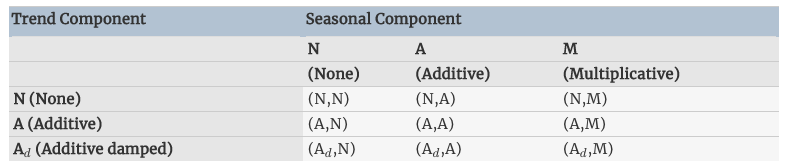

It is especially important, cause this will be useful for using ExponentialSmoothing from darts package:

- (N,N) is simple exponential smoothing
- (A,N) is Holt's linear trend method
- (A,A) corresponds to additive Holt-Winters method

In [29]:
from darts.utils.utils import ModelMode, SeasonalityMode
name = "Exponential Smoothing"
# Suppress FutureWarning
ets_model = ExponentialSmoothing(trend=None, damped=False, seasonal=None, seasonal_periods=50, random_state=42)
y_pred, metrics = eval_model(ets_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ets_predictions")
pred_df = pd.concat([pred_df, y_pred], axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [30]:
fig = plot_forecast(pred_df, forecast_columns=["ets_predictions"], forecast_display_names=['Exponential Smoothing Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

In [31]:
name = "Holt-Winters"
hw_model = ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=50, random_state=42)
y_pred, metrics = eval_model(hw_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "ht_predictions")
pred_df = pd.concat([pred_df, y_pred], axis=1)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [32]:
fig = plot_forecast(pred_df, forecast_columns=["ht_predictions"], forecast_display_names=['Holt-Winters'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### Theta Forecast

Theta Model created in 2000 was one of the top submissions in the M3 forecasting competition. The idea which stays behind this model was to modify the local curvatures of the time series, fitting two $Θ$ lines (originally $Θ_{1} = 0$ and $Θ_{2} = 2$) with a following equation:
$X_{new}''(\theta) = \theta*X_{data}''$     
where $X_{data}'' = X_{t} - 2X_{t-1} + X_{t-2}$ at time t.

Based on the above equation, the lower the $Θ$ the larger degree of deflation, where if $Θ$ = 0, then we end with linear regression. Prediction is the simple average.
Later the method was simplified, because it was proved that we can use ETS with
a drift term to get equivalent results to the original Theta method, which is what is adapted into most
of the implementations of the method that exist today. This implementation follows the rules:

1. Check for seasonality and extract seasonality if the series is seasonal. This step creates a new deseasonalized time series, $y_{new}$.
2. Use SES on the deseasonalized time series $y_{new}$, and retrieve the estimated smoothing parameter, $α$.
3. Fit a linear trend on $(1-\theta) * y_{new}$ and retrieve the estimated coefficient, $b_{Θ}$.
4. $y_{t+H} = SES_{t+H} + b_{\theta} * T_{t+H}$,  where $SES_{t+H}$ is the SET forecast for timesteps $t$ to $t+H$ and $T_{t+H}$ is
an array denoting time, $[t, t+1, t+2, ... t+H]$.
5. Reseasonalize if the data was deseasonalized in the beginning.

Advantages:
- Ease of Interpretation
- Flexibility

Disadvantages:
- Dependence on Data Stability
- Limited Effectiveness for More Complex Data
- Sensitive to outliers

In [33]:
from numpy.core import fromnumeric
from darts.models import FourTheta

name = "Theta"
theta_model = FourTheta(theta=3, seasonality_period=50, season_mode=SeasonalityMode.ADDITIVE)
y_pred, metrics = eval_model(theta_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "theta_predictions")
pred_df = pred_df.join(y_pred)

In [34]:
fig = plot_forecast(pred_df, forecast_columns=["theta_predictions"], forecast_display_names=['Theta Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### Fast Fourier Transform Forecast

In [35]:
name = "FFT"
fft_model = FFT(nr_freqs_to_keep=35, trend="poly", trend_poly_degree=2)
y_pred, metrics = eval_model(fft_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "fft_predictions")
pred_df = pred_df.join(y_pred)

In [36]:
fig = plot_forecast(pred_df, forecast_columns=["fft_predictions"], forecast_display_names=['FFT Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### Prophet

Another disadvantege of ES is that it can only handle one seasonal pattern at the time. That's why the team of scientist from Facebook created a Prophet model, where: $X_t = T_t + S_t + H_t + ɛ_t$

The idea of Prophet is relied on Kolmogorov-Arnold theorem, which states that each multivariate function can represented as sums and compositions of univariate functions. However, we need simplification to this theorem, a reflection of which can be mathematical equation of GAM model where $ϕ^{-1}[E(Y)] = β_{0} + f_{1}(x_{1}) + f_{2}(x_{2}) + ... + f_{m}(x_m)$. \
In the context of Prophet, a similar reasoning is taking shape, i.e., the trend, seasonality and holiday component are separate functions, where for each of them we can check the final impact on the predictions.

##### Trend

Prophet library contains two possible trend models, one Piecewise Linear Model with a constant rate of growth.
Second is Nonlinear growth, represented in the form of logistic growth model.

##### Seasonality

There can be multiple seasonal patterns in the data at the same time, which is something that the ARIMA model, for example, does not handle very well (dummies need to be added, for example). The idea is that for one set of data, for example, there can be seasonality for, say, morning hours and evening hours (intraday data), or weekend, rest of week type seasonality. Using Fourier expansion on the seasonality function, this problem was handled quite well.

##### Holidays

We certainly cannot consider holidays or major events as a random component. The Prophet approach to modeling unusual days is to provide a customized list of events. We assume that the effects are independent, so if, for example, a sports event takes place near a public holiday, their effects will be included separately.

For the sake of the exercise, I decided to use Prophet model with default params. Moreover, Prophet from the darts package has truncated functionality compared to the package prepared by Facebook.

In [37]:
# from prophet import Prophet
from darts.models import Prophet

In [38]:
name = "Prophet"
prophet_model = Prophet()

y_pred, metrics = eval_model(prophet_model, ts_train, ts_test, name=name)
metric_record.append(metrics)
y_pred = format_y_pred(y_pred, "prophet_predictions")
pred_df = pred_df.join(y_pred)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuwazncje/j42qcnvi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuwazncje/2qf8463o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19936', 'data', 'file=/tmp/tmpuwazncje/j42qcnvi.json', 'init=/tmp/tmpuwazncje/2qf8463o.json', 'output', 'file=/tmp/tmpuwazncje/prophet_modelazbincj1/prophet_model-20240523191026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:10:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:10:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [39]:
fig = plot_forecast(pred_df, forecast_columns=["prophet_predictions"], forecast_display_names=['Prophet Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

Among the aforementioned example solutions, ARIMA models should also be mentioned. In this project, however, I have decided not to focus on this "family" of models since I dedicated a lot of time to them in previous projects. I want to concentrate solely on learning new techniques and solutions, without the pressure to achieve the best possible result.

### ML approach

In [40]:
walmart.drop('forecastability_COV', axis='columns', inplace=True)

#### Feature engineering
Horizon = 17, because there are 17 weeks in test

In [41]:
def create_features(df, horizon=17, lags = [1, 2, 4, 12, 24], wins = [4, 12], if_horizon=True):

   # Future values for our y
    for horizon in range(1, horizon+1):
      # Zmienne objaśniane
      df[f'Weekly_Sales_horizon_{horizon}W'] = df['Weekly_Sales'].shift(-horizon)

   # Lags
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[["Store","Weekly_Sales"]].groupby("Store")["Weekly_Sales"].shift(lag).fillna(-1)

   # Rolling stats
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            df[f"rmean_{lag}_{win}"] = df[["Store", lag_col]].groupby("Store")[lag_col].transform(lambda x : x.rolling(win).mean()).fillna(-1)
            df[f"rmedian_{lag}_{win}"] = df[["Store", lag_col]].groupby("Store")[lag_col].transform(lambda x : x.rolling(win).median()).fillna(-1)
            df[f"rstd_{lag}_{win}"] = df[["Store", lag_col]].groupby("Store")[lag_col].transform(lambda x : x.rolling(win).std()).fillna(-1)

    # Day in the year - seasonality (sin/cos)
    df['day_of_year'] = df.Date.dt.dayofyear
    df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year']/366)
    df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year']/366)
    df.drop('day_of_year', axis='columns', inplace=True)

    # Encode categorical features (meta features)
    cat_feats = ['month','weekday']
    for cc in cat_feats:
        le = LabelEncoder()
        df[cc] = le.fit_transform(df[cc])
        # df.drop(cc, axis='columns', inplace=True)

    return df

walmart_transformed = create_features(walmart)

walmart_transformed.head(3)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,...,rmedian_4_12,rstd_4_12,rmean_12_12,rmedian_12_12,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,3,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.579421,0.815028
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,3,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.672949,0.739689
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,3,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.756771,0.653680


In [42]:
walmart['year'] = walmart['year'].astype('int32')
target_columns = [f'Weekly_Sales_horizon_{horizon}W' for horizon in range(1, 18)]

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rmedian_4_12,rstd_4_12,rmean_12_12,rmedian_12_12,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,735955.760,46142.637917,796056.575000,797987.64,36483.786189,782969.067500,782383.305,65181.794548,-0.999079,-0.042905
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,735955.760,41765.494005,793819.520000,797987.64,38545.854032,795684.075833,782383.305,42200.646554,-0.997018,0.077175
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,733667.595,37866.350553,795989.667500,797987.64,33953.875865,791870.820000,782383.305,47691.478609,-0.980575,0.196143
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,729383.415,36996.378554,790103.909167,797987.64,41765.544994,790091.116667,782135.640,47610.074407,-0.949990,0.312281
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,724407.855,17636.366645,786374.087500,797987.64,45507.525910,782727.251667,779612.330,42575.281009,-0.905702,0.423914


6430    733455.07
6431    734464.36
6432    718125.53
6433    760281.43
6434          NaN
Name: Weekly_Sales_horizon_1W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-14990926821.748623

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


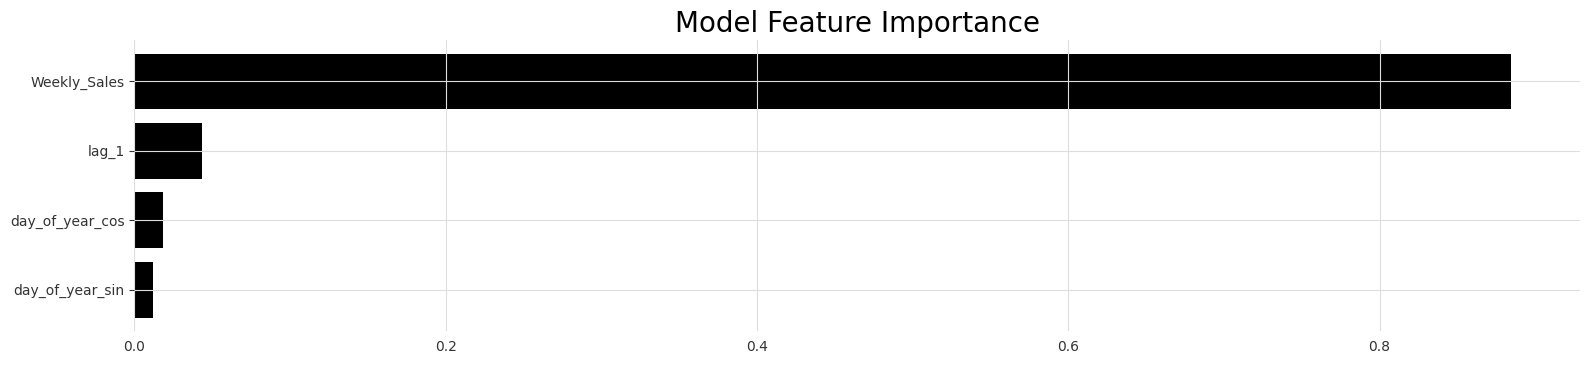

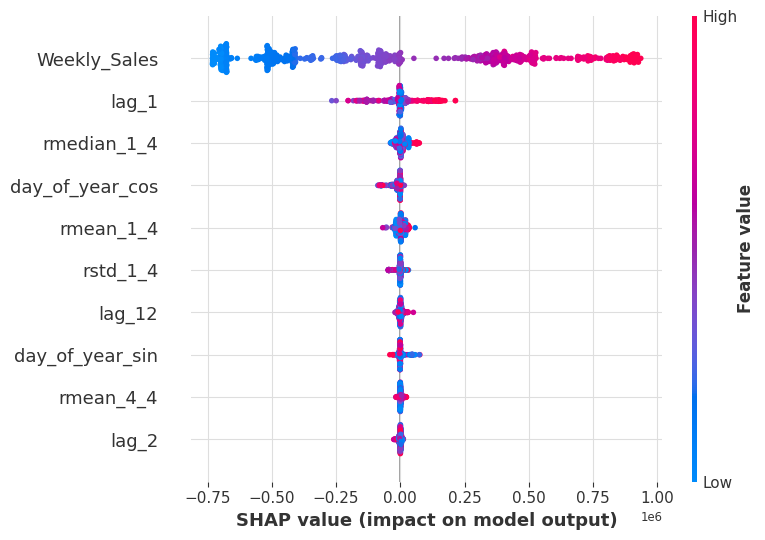

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rstd_4_12,rmean_12_12,rmedian_12_12,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,46142.637917,796056.575000,797987.64,36483.786189,782969.067500,782383.305,65181.794548,-0.999079,-0.042905,734267.227200
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,41765.494005,793819.520000,797987.64,38545.854032,795684.075833,782383.305,42200.646554,-0.997018,0.077175,737552.105295
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,37866.350553,795989.667500,797987.64,33953.875865,791870.820000,782383.305,47691.478609,-0.980575,0.196143,748764.680896
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,36996.378554,790103.909167,797987.64,41765.544994,790091.116667,782135.640,47610.074407,-0.949990,0.312281,749273.030352
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,17636.366645,786374.087500,797987.64,45507.525910,782727.251667,779612.330,42575.281009,-0.905702,0.423914,763016.703406


6430    734464.36
6431    718125.53
6432    760281.43
6433          NaN
6434          NaN
Name: Weekly_Sales_horizon_2W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-14191879520.38184

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}

Evaluation charts


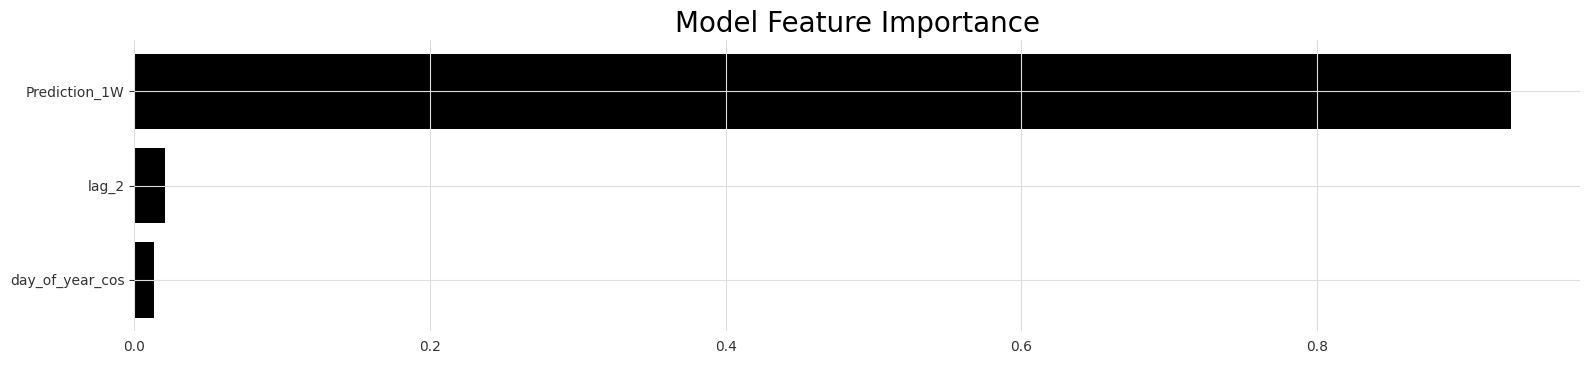

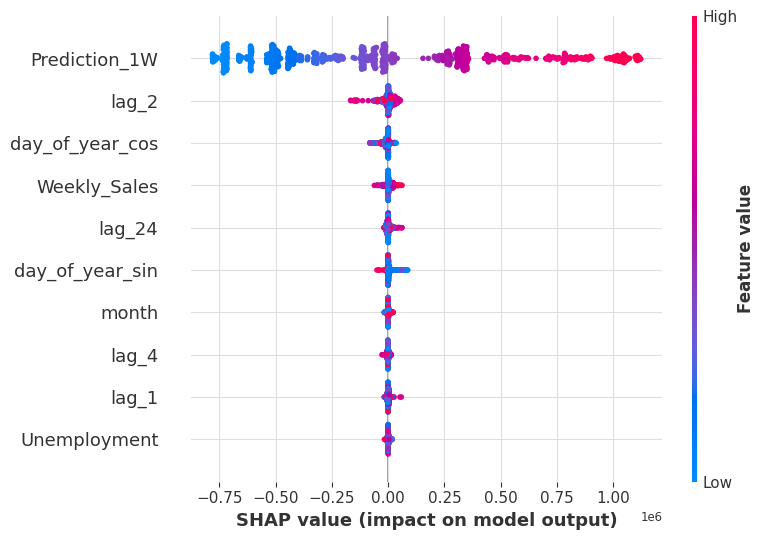

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rmean_12_12,rmedian_12_12,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,796056.575000,797987.64,36483.786189,782969.067500,782383.305,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,793819.520000,797987.64,38545.854032,795684.075833,782383.305,42200.646554,-0.997018,0.077175,737552.105295,748412.108703
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,795989.667500,797987.64,33953.875865,791870.820000,782383.305,47691.478609,-0.980575,0.196143,748764.680896,748377.057803
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,790103.909167,797987.64,41765.544994,790091.116667,782135.640,47610.074407,-0.949990,0.312281,749273.030352,759003.477315
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,786374.087500,797987.64,45507.525910,782727.251667,779612.330,42575.281009,-0.905702,0.423914,763016.703406,804221.783110


6430    718125.53
6431    760281.43
6432          NaN
6433          NaN
6434          NaN
Name: Weekly_Sales_horizon_3W, dtype: float64


Evaluation charts


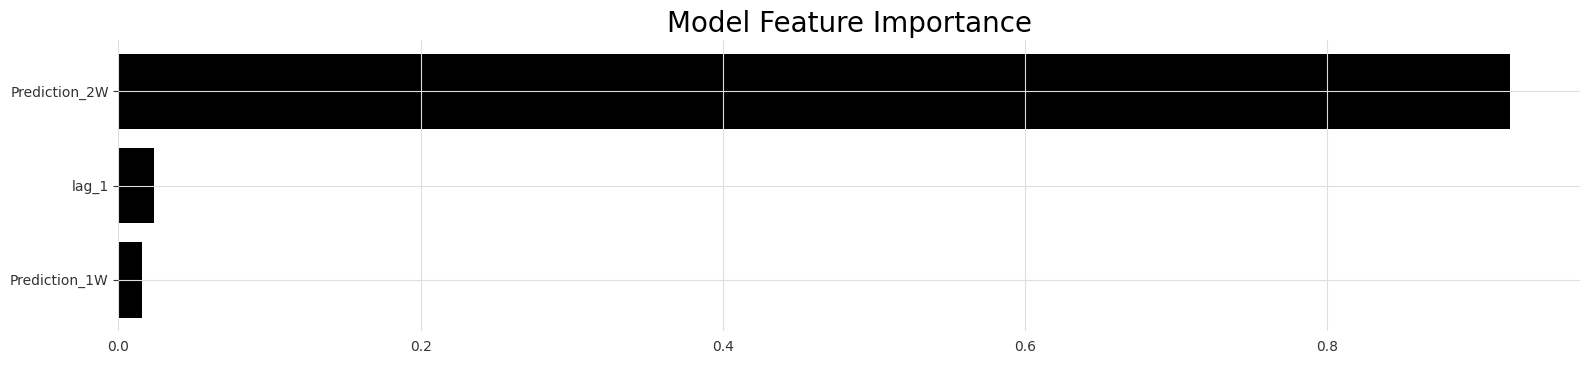

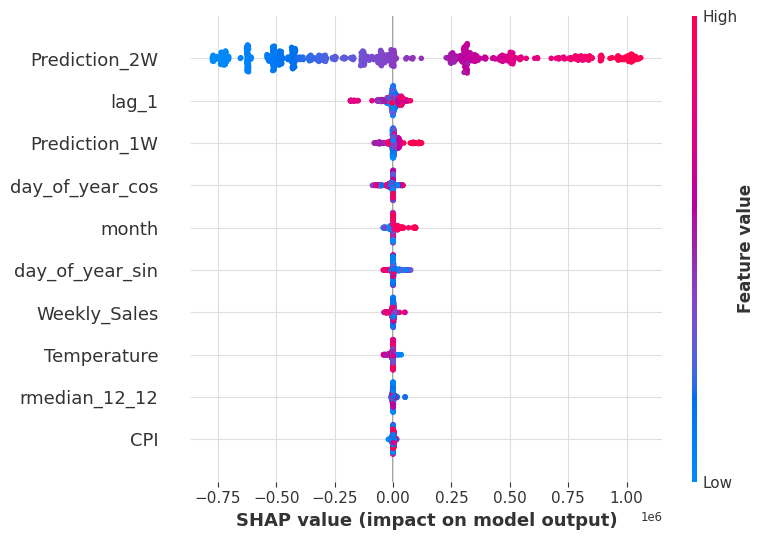

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rmedian_12_12,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,797987.64,36483.786189,782969.067500,782383.305,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,797987.64,38545.854032,795684.075833,782383.305,42200.646554,-0.997018,0.077175,737552.105295,748412.108703,746806.644047
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,797987.64,33953.875865,791870.820000,782383.305,47691.478609,-0.980575,0.196143,748764.680896,748377.057803,747058.716690
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,797987.64,41765.544994,790091.116667,782135.640,47610.074407,-0.949990,0.312281,749273.030352,759003.477315,766106.927728
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,797987.64,45507.525910,782727.251667,779612.330,42575.281009,-0.905702,0.423914,763016.703406,804221.783110,807165.395876


6430    760281.43
6431          NaN
6432          NaN
6433          NaN
6434          NaN
Name: Weekly_Sales_horizon_4W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-12924251830.974537

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}


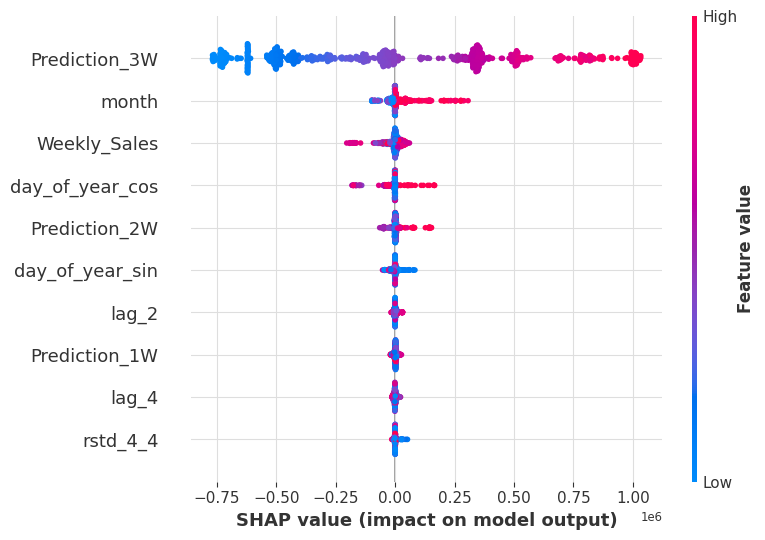

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rstd_12_12,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,36483.786189,782969.067500,782383.305,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,38545.854032,795684.075833,782383.305,42200.646554,-0.997018,0.077175,737552.105295,748412.108703,746806.644047,813944.816606
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,33953.875865,791870.820000,782383.305,47691.478609,-0.980575,0.196143,748764.680896,748377.057803,747058.716690,774157.770391
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,41765.544994,790091.116667,782135.640,47610.074407,-0.949990,0.312281,749273.030352,759003.477315,766106.927728,793423.104424
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,45507.525910,782727.251667,779612.330,42575.281009,-0.905702,0.423914,763016.703406,804221.783110,807165.395876,937597.646642


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_5W, dtype: float64

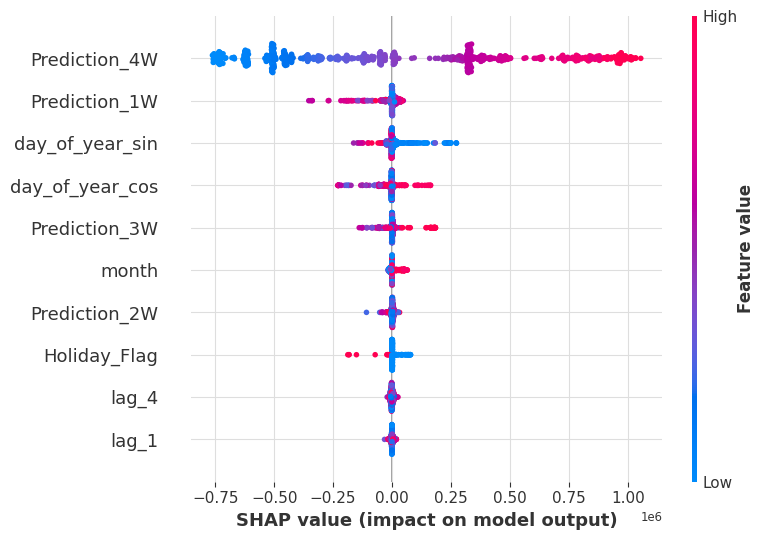

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rmean_24_12,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,782969.067500,782383.305,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,795684.075833,782383.305,42200.646554,-0.997018,0.077175,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,791870.820000,782383.305,47691.478609,-0.980575,0.196143,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,790091.116667,782135.640,47610.074407,-0.949990,0.312281,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,782727.251667,779612.330,42575.281009,-0.905702,0.423914,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_6W, dtype: float64


Evaluation charts


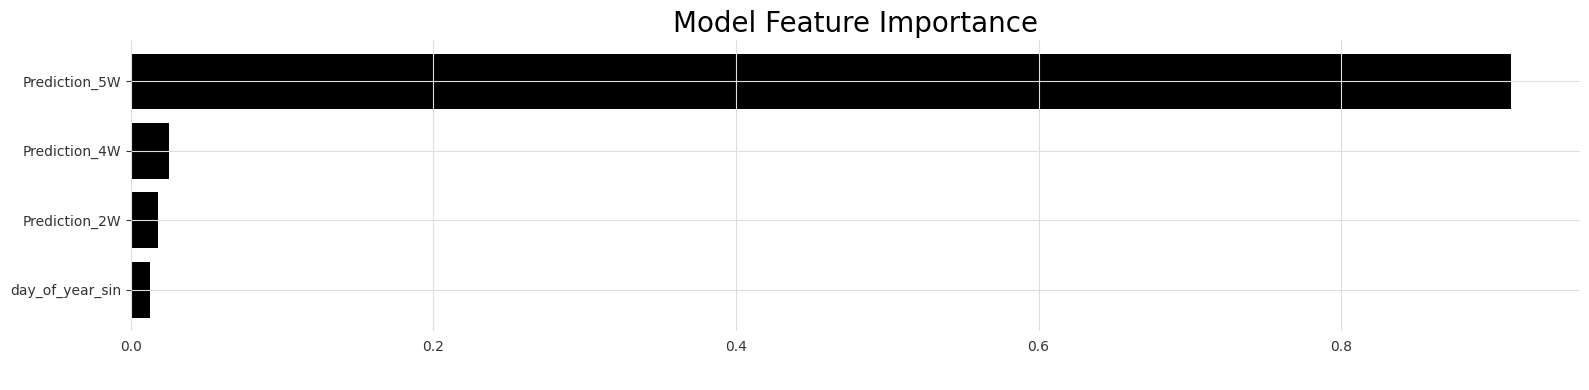

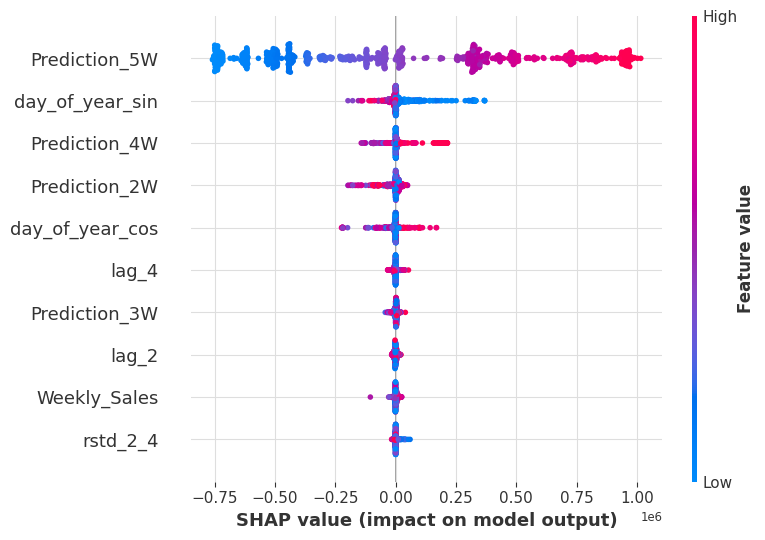

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rmedian_24_12,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,782383.305,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,782383.305,42200.646554,-0.997018,0.077175,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,782383.305,47691.478609,-0.980575,0.196143,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,782135.640,47610.074407,-0.949990,0.312281,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,779612.330,42575.281009,-0.905702,0.423914,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_7W, dtype: float64

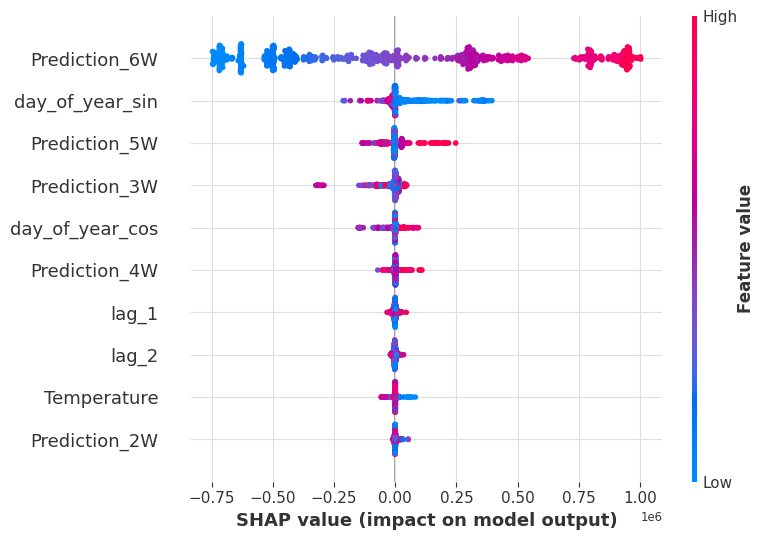

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,rstd_24_12,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,65181.794548,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,42200.646554,-0.997018,0.077175,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,47691.478609,-0.980575,0.196143,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,47610.074407,-0.949990,0.312281,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,42575.281009,-0.905702,0.423914,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_8W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-11706382327.53864

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}


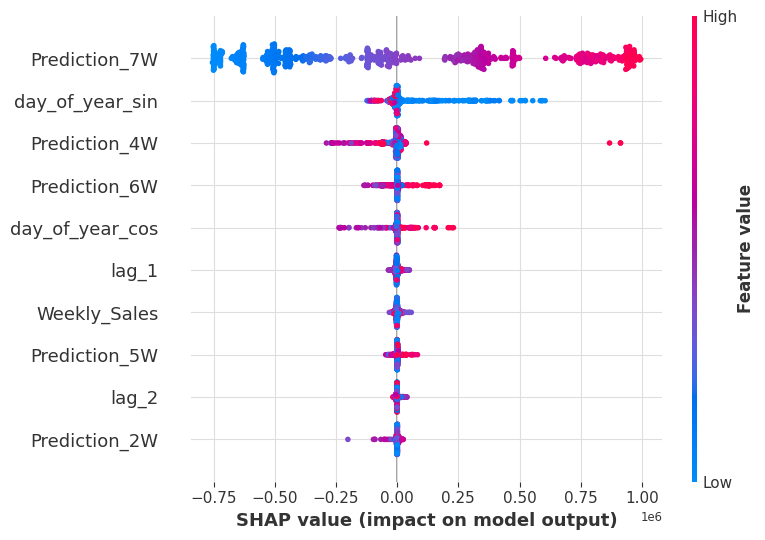

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,day_of_year_sin,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,-0.999079,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,-0.997018,0.077175,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,-0.980575,0.196143,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,-0.949990,0.312281,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,-0.905702,0.423914,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_9W, dtype: float64

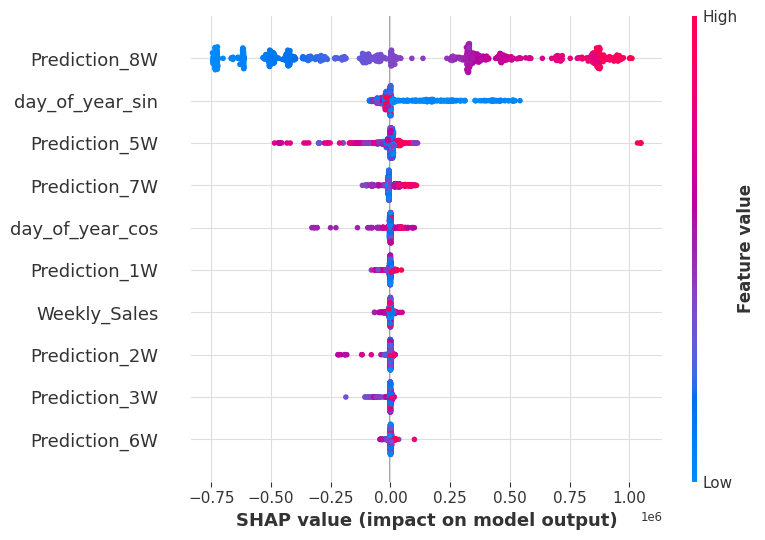

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,day_of_year_cos,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,-0.042905,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,0.077175,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,0.196143,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,0.312281,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,0.423914,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_10W, dtype: float64


Evaluation charts


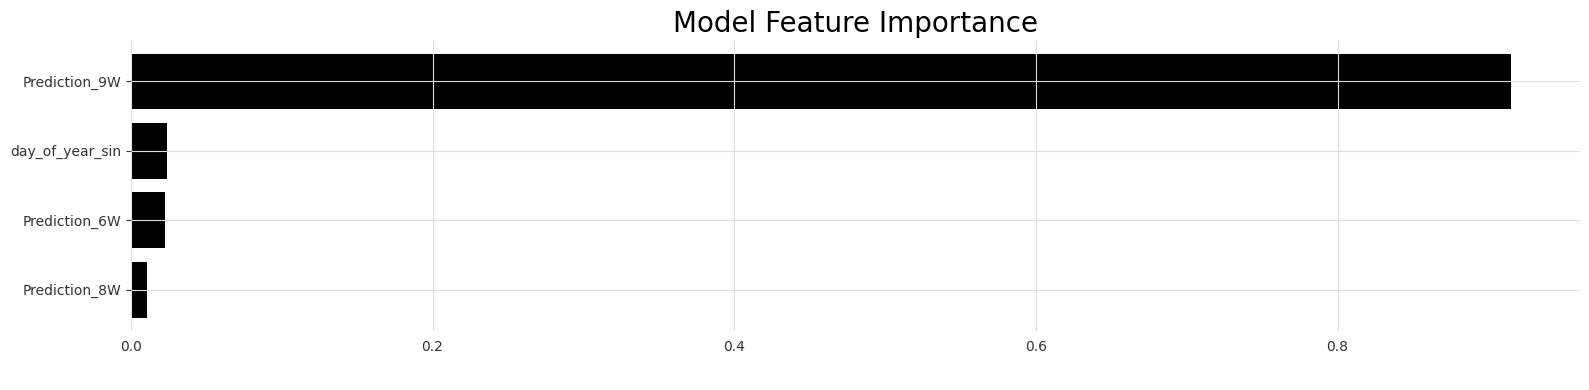

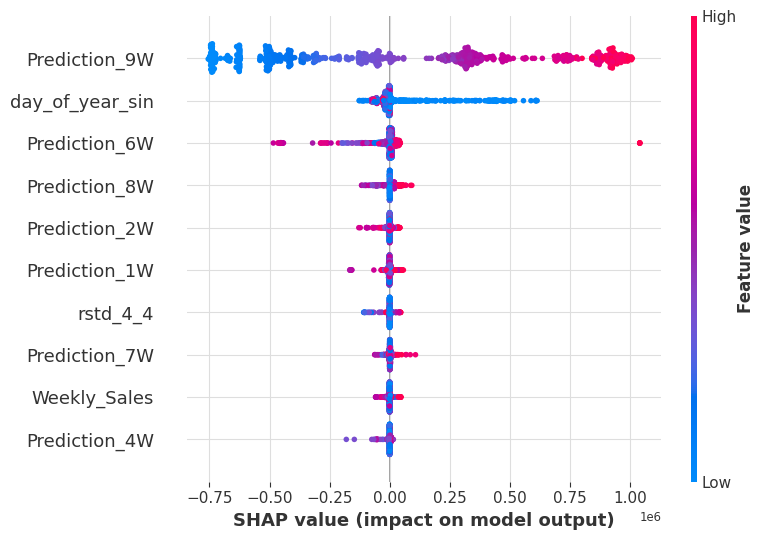

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_1W,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,734267.227200,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,737552.105295,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,748764.680896,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,749273.030352,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,763016.703406,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_11W, dtype: float64

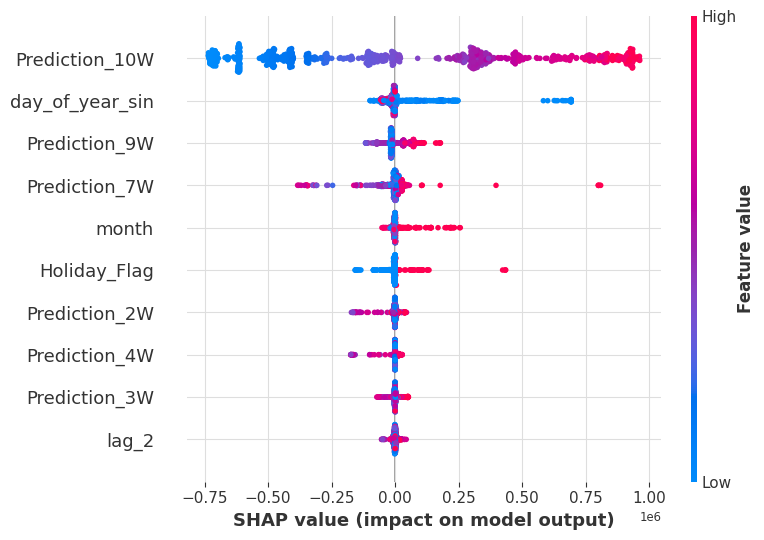

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_2W,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,749842.048574,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,748412.108703,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,748377.057803,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,759003.477315,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,804221.783110,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_12W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-11109030135.83095

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}


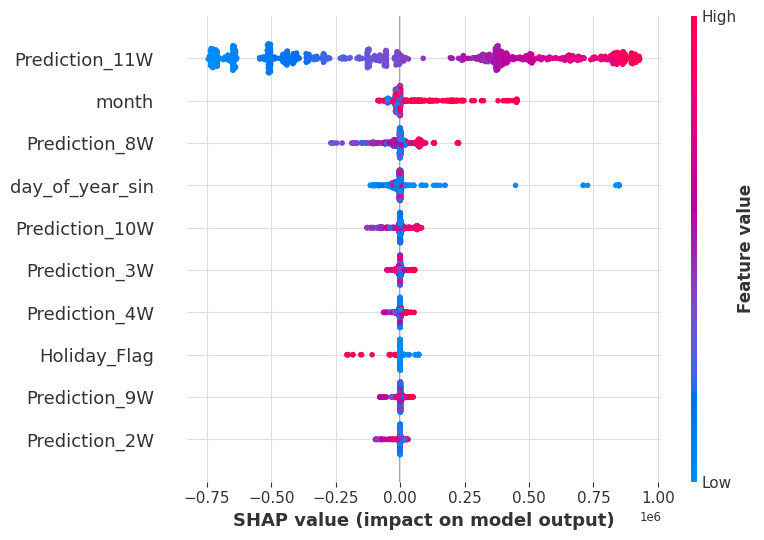

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_3W,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W,Prediction_12W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,753970.815480,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06,1.364036e+06
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,746806.644047,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06,9.679147e+05
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,747058.716690,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05,7.777746e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,766106.927728,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05,9.683418e+05
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,807165.395876,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05,8.348680e+05


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_13W, dtype: float64

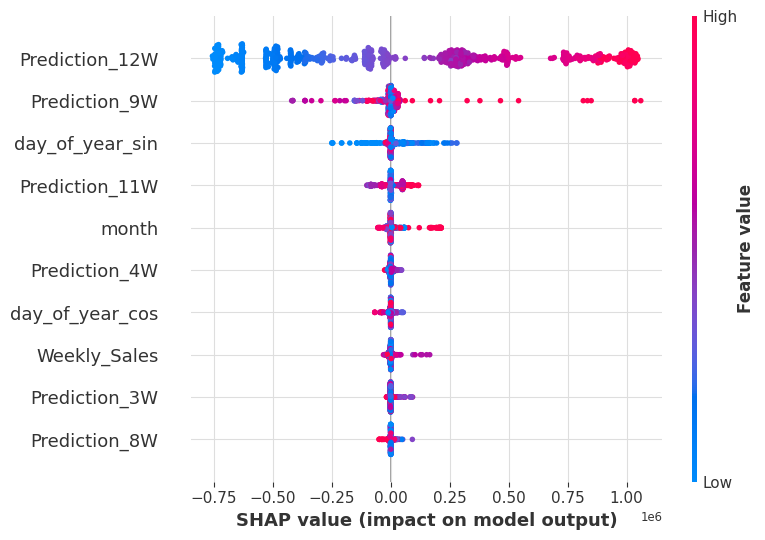

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_4W,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W,Prediction_12W,Prediction_13W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,824219.071413,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06,1.364036e+06,786028.577021
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,813944.816606,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06,9.679147e+05,981406.828531
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,774157.770391,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05,7.777746e+05,745965.635432
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,793423.104424,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05,9.683418e+05,984118.468790
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,937597.646642,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05,8.348680e+05,842153.675650


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_14W, dtype: float64

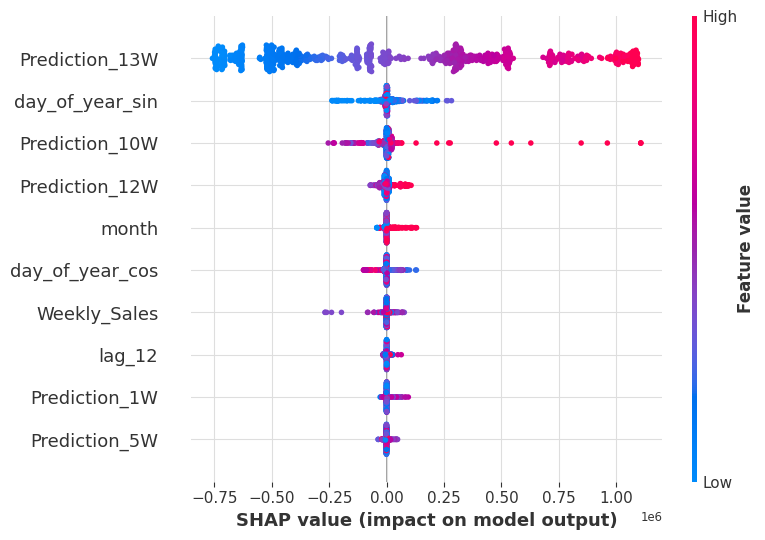

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_5W,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W,Prediction_12W,Prediction_13W,Prediction_14W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,8.786444e+05,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06,1.364036e+06,786028.577021,781912.378131
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,8.450870e+05,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06,9.679147e+05,981406.828531,959453.434368
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,8.359772e+05,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05,7.777746e+05,745965.635432,728705.472628
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,9.085032e+05,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05,9.683418e+05,984118.468790,984363.160906
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,1.008311e+06,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05,8.348680e+05,842153.675650,881442.999112


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_15W, dtype: float64

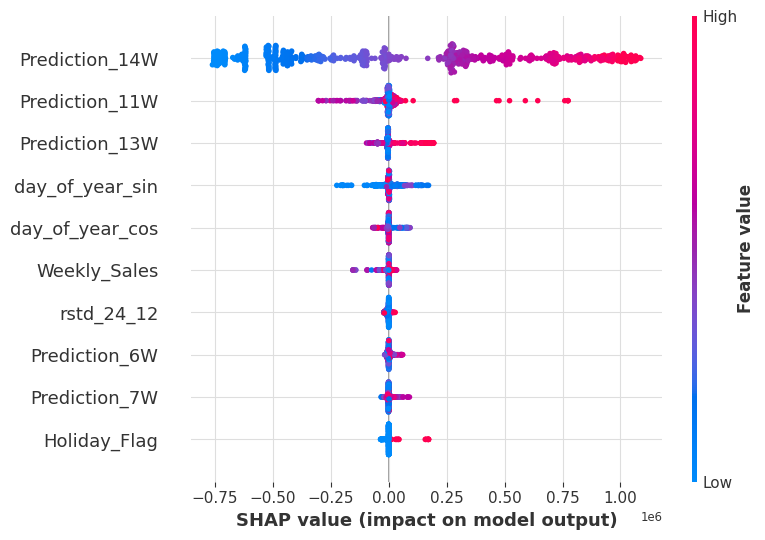

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_6W,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W,Prediction_12W,Prediction_13W,Prediction_14W,Prediction_15W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,8.688781e+05,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06,1.364036e+06,786028.577021,781912.378131,745426.015602
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,8.527880e+05,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06,9.679147e+05,981406.828531,959453.434368,867524.599409
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,9.892178e+05,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05,7.777746e+05,745965.635432,728705.472628,684552.335420
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,9.450731e+05,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05,9.683418e+05,984118.468790,984363.160906,999479.868313
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,1.005296e+06,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05,8.348680e+05,842153.675650,881442.999112,905557.644502


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_16W, dtype: float64

Fitting 5 folds for each of 6 candidates, totalling 30 fits
The best estimator: 
Pipeline(steps=[('regressor',
                 RandomForestRegressor(max_depth=15, min_samples_leaf=3,
                                       random_state=123))])

The best score: 
-15701932238.572048

The best parameters: 
{'regressor__criterion': 'squared_error', 'regressor__max_depth': 15, 'regressor__min_samples_leaf': 3, 'regressor__n_estimators': 100}


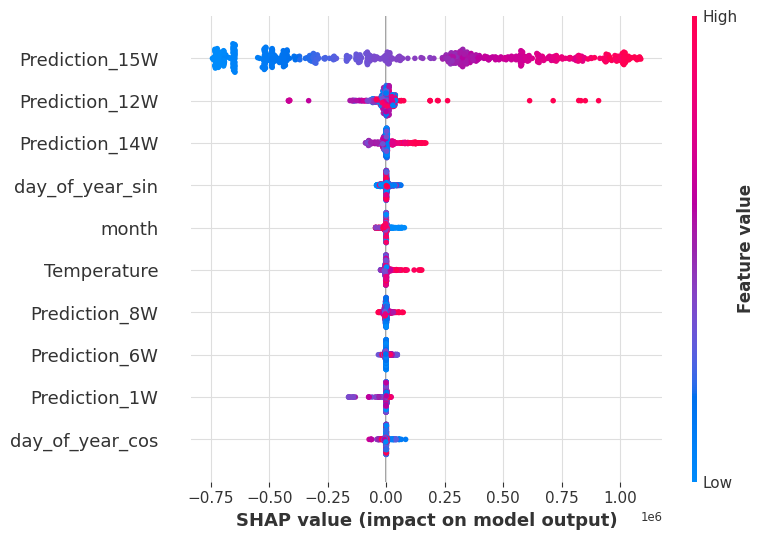

None

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,weekday,lag_1,...,Prediction_7W,Prediction_8W,Prediction_9W,Prediction_10W,Prediction_11W,Prediction_12W,Prediction_13W,Prediction_14W,Prediction_15W,Prediction_16W
6430,713173.95,0,64.88,3.997,192.013558,8.684,2012,11,0,723086.20,...,9.557054e+05,1.307119e+06,8.376104e+05,9.620877e+05,1.067295e+06,1.364036e+06,786028.577021,781912.378131,745426.015602,7.296169e+05
6431,733455.07,0,64.89,3.985,192.170412,8.667,2012,10,0,713173.95,...,1.065274e+06,1.058309e+06,1.052671e+06,1.117585e+06,1.467545e+06,9.679147e+05,981406.828531,959453.434368,867524.599409,8.593122e+05
6432,734464.36,0,54.47,4.000,192.327265,8.667,2012,10,0,733455.07,...,9.830437e+05,1.102608e+06,1.125787e+06,1.285003e+06,8.493446e+05,7.777746e+05,745965.635432,728705.472628,684552.335420,6.803059e+05
6433,718125.53,0,56.47,3.969,192.330854,8.667,2012,10,0,734464.36,...,9.713745e+05,1.067907e+06,1.314002e+06,9.651649e+05,9.802685e+05,9.683418e+05,984118.468790,984363.160906,999479.868313,1.028499e+06
6434,760281.43,0,58.85,3.882,192.308899,8.667,2012,10,0,718125.53,...,1.094026e+06,1.174757e+06,9.247749e+05,8.665075e+05,8.477388e+05,8.348680e+05,842153.675650,881442.999112,905557.644502,9.591920e+05


6430   NaN
6431   NaN
6432   NaN
6433   NaN
6434   NaN
Name: Weekly_Sales_horizon_17W, dtype: float64

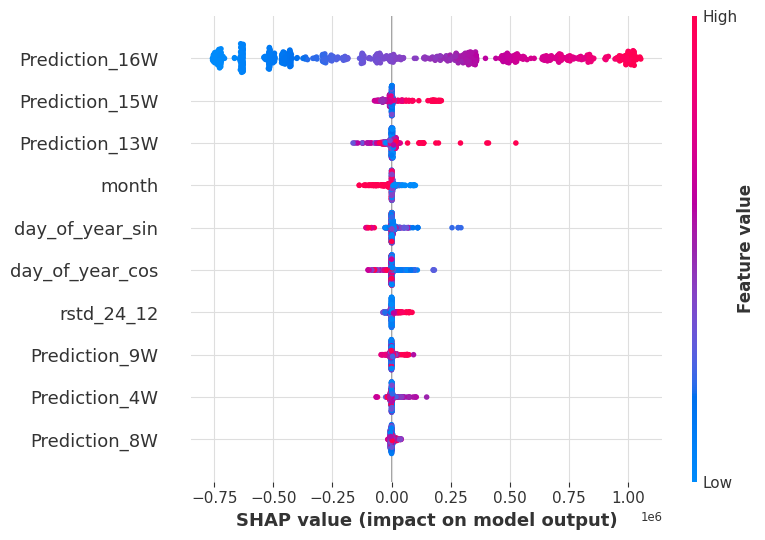

None

In [43]:
walmart_copied = walmart_transformed.copy()

for idx, horizon in enumerate(target_columns, start=1):

    # Split train/test
    X = walmart_transformed.drop([*target_columns] + ['Store', 'Date'], axis = 1).copy()
    y = walmart_transformed[horizon].copy()

    train_set = walmart_transformed[~test_mask].copy()
    X_train = train_set.drop([*target_columns] + ['Store', 'Date'], axis = 1)
    y_train = train_set[horizon].copy()

    test_set = walmart_transformed[test_mask].copy()
    X_test = test_set.drop([*target_columns] + ['Store', 'Date'], axis = 1)
    y_test = test_set[horizon].copy()

    display(X_test.tail())
    display(y_test.tail())

    # Hyperparams
    random_forest_pipeline = Pipeline(steps=[('regressor', RandomForestRegressor(random_state=123))])

    # squared_error is MSE, phrase "mse" is deprecated
    param_random_forest = {
        'regressor__max_depth': [5, 10, 15],
        'regressor__min_samples_leaf': [3, 7],
        'regressor__n_estimators': [100],
        'regressor__criterion': ['squared_error'],
    }

    if idx in [1, 2, 4, 8, 12, 16]:
        random_forest = GridSearchCV(random_forest_pipeline, param_random_forest,
                                     cv=TimeSeriesSplit(n_splits=5).split(X_train), n_jobs=3,
                                     scoring = 'neg_mean_squared_error', verbose=10)
        random_forest.fit(X_train, y_train)
        print("The best estimator: ", random_forest.best_estimator_,
              "\nThe best score: ", random_forest.best_score_,
              "\nThe best parameters: ", random_forest.best_params_, sep="\n")

        random_forest_model = random_forest.best_estimator_
        best_params = random_forest.best_params_
    else:
        random_forest_model = random_forest_pipeline.set_params(**best_params)
        random_forest_model.fit(X_train, y_train)

    # Add forecast
    walmart_transformed[f'Prediction_{idx}W'] = random_forest_model.predict(X)
    dataset_copied = pd.merge(walmart_copied,
                              walmart_transformed[['Date', 'Store',
                                       f'Prediction_{idx}W']],
                              how='left',
                              on=['Date', 'Store'])

    if idx in [1, 2, 3, 6, 10, 25, 52]:
        print('\nEvaluation charts')
        ### Evaluation check
        # model_evaluation(model = random_forest_model,
        #                  Xtrain = X_train, ytrain = y_train,
        #                  Xtest  = X_test,  ytest  = y_test)

        importance = random_forest_model._final_estimator.feature_importances_
        df_feature_importance=importance.argsort()
        df_feature_importance=pd.DataFrame({
            'column':X_train.columns[df_feature_importance],
            'importance':importance[df_feature_importance]
        })
        df_feature_importance = df_feature_importance[
                                                df_feature_importance['importance']>=0.01].copy().reset_index(drop=True)
        plt.figure(figsize=(16, 4))
        plt.barh(df_feature_importance['column'][-10:], df_feature_importance['importance'][-10:])
        plt.tick_params(axis='both', labelsize=10)
        plt.title('Model Feature Importance', size=20)
        plt.xlabel(' ', size=15)
        plt.tight_layout()
        plt.show()

    ### model interpretability
    explainer = shap.TreeExplainer(random_forest_model.named_steps["regressor"])
    shap_values = explainer.shap_values(X_test, approximate=True)
    p = shap.summary_plot(shap_values, X_test, max_display=10)
    display(p)

In [44]:
pred_df = pd.concat([pred_df, walmart_transformed[walmart_transformed.Store == 1]["Prediction_1W"].set_axis(pred_df.index)], axis=1)

In [45]:
test_store_1_rf = pred_df.loc['2012-07-06':]
ts_rf_res = TimeSeries.from_series(test_store_1_rf['Prediction_1W'])

In [46]:
metrics = {
        "Algorithm": 'Global_RF_pred',
        "MAE": mae(actual_series=ts_test, pred_series=ts_rf_res),
        "MSE": mse(actual_series=ts_test, pred_series=ts_rf_res),
        "MASE": mase(actual_series=ts_test, pred_series=ts_rf_res, insample=ts_train),
        "Forecast Bias": forecast_bias(y_true=ts_test, y_pred=ts_rf_res)
         }

In [47]:
metrics

{'Algorithm': 'Global_RF_pred',
 'MAE': 56295.03238002594,
 'MSE': 4132061880.1567426,
 'MASE': 0.45422591401490975,
 'Forecast Bias': -1.505646994661012}

In [48]:
def eval_model(model, ts_train, ts_test, y_pred, name=None):
    if name is None:
        name = type(model).__name__
    else:
        try:
          model.fit(ts_train)
          y_pred = model.predict(len(ts_test))
          return y_pred, {
              "Algorithm": name,
              "MAE": mae(actual_series = ts_test, pred_series = y_pred),
              "MSE": mse(actual_series = ts_test, pred_series = y_pred),
              "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
              "Forecast Bias": forecast_bias(y_true = ts_test, y_pred = y_pred)}
        except:
          print("Can't fit model")
    return {
            "Algorithm": name,
            "MAE": mae(actual_series = ts_test, pred_series = y_pred),
            "MSE": mse(actual_series = ts_test, pred_series = y_pred),
            "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
            "Forecast Bias": forecast_bias(y_true = ts_test, y_pred = y_pred)}

In [49]:
metrics = eval_model(None, ts_train, ts_test, ts_rf_res, 'Random Forest')
metric_record.append(metrics)

Can't fit model


In [50]:
fig = plot_forecast(pred_df, forecast_columns=["Prediction_1W"], forecast_display_names=['Global RF pred'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_yaxes(range=[1400000, 1800000])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### NBeats

Up until a certain point, there was a belief that Machine Learning (ML)/Deep Learning (DL) methods couldn't perform as well on time series problems compared to classical econometric methods. However, this perception changed in 2018 when the ES-RNN model, a combination of the Holt-Winters method with a Recurrent Neural Network (RNN), won the M4 competition. In this model, the RNN assisted in determining the trend. This was a significant breakthrough in the application of neural networks to time series and marked the beginning of further groundbreaking discoveries.

Just a year later, the NBeats model was developed, where the authors achieved much better results (which is exceptionally challenging in the field of time series) compared to the winning solution of the previous year.

At first glance, the architecture of NBeats may seem complicated, but upon closer inspection, it's constructed from stacks and blocks. Each block utilizes feedforward network with 4 layers. The input to such a block is a horizon of nH backward observations, and the output is a backtest prediction (for nH observations) and a prediction for 5 periods ahead. \
Each block generates a partial forecast focused on the local characteristics of the time series.
The stack aggregates the partial forecasts across the blocks it comprises and then hands the result over to the next stack. The stacks purpose is to identify non-local patterns along the complete time axis by “looking back.” In that case, the final global $\hat{y}_{t}$ forecast by is the sum of all partial forecasts, while the backcasts are subtracted from the previous inputs to create the input for the following block.

Below, I present the graphical concept of this architecture, directly from the authors: ([source](https://arxiv.org/abs/1905.10437)).

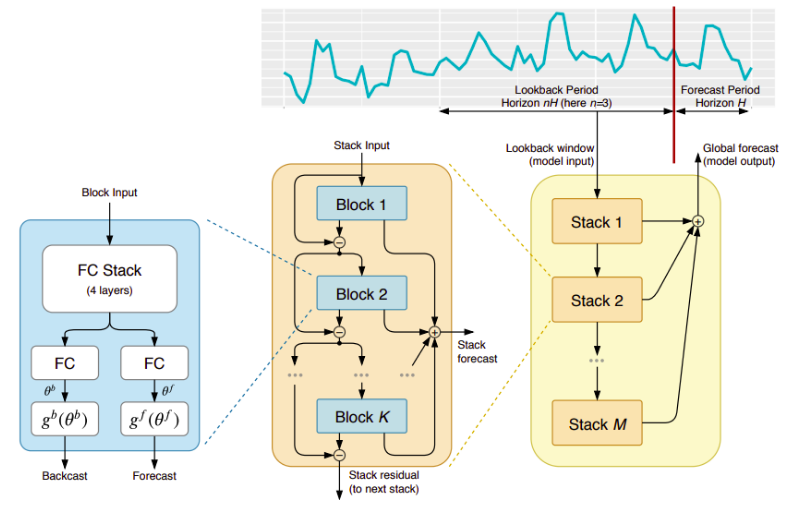

In [51]:
train_baseline_2 = train[train.Store == 2]["Weekly_Sales"].set_axis(train[train.Store == 2]["Date"])
test_baseline_2 = test[test.Store == 2]["Weekly_Sales"].set_axis(test[test.Store == 2]["Date"])

ts_train_2 = TimeSeries.from_series(train_baseline_2)
ts_test_2 = TimeSeries.from_series(test_baseline_2)

In [ ]:
time_series_list = [ts_train]
scaler = Scaler()
time_series_scaled = [scaler.fit_transform(ts) for ts in time_series_list]

model_nbeats = NBEATSModel(
    input_chunk_length=26,
    output_chunk_length=17,
    n_epochs=20,
    random_state=0
)
model_nbeats.fit(time_series_scaled, verbose=False)

pred_ts_train = model_nbeats.predict(n=17)
predictions = [scaler.inverse_transform(pred) for pred in pred_ts_train]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
output_chunk_length = 17
preds_1_test = []
for i in range(output_chunk_length):
  preds_1_test.append(predictions[i].values()[0].tolist()[0])

In [ ]:
metrics = eval_model(None, ts_train, ts_test, TimeSeries.from_series(pd.Series(preds_1_test, index=pd.date_range(start='2012-07-06', periods=17, freq='W-FRI'))), 'NBeats one series')
metric_record.append(metrics)

Can't fit model


In [ ]:
preds_1_test = [*train_baseline.values.tolist(), *preds_1_test]

In [ ]:
pred_df['nbeats_predictions'] = preds_1_test

In [ ]:
fig = plot_forecast(pred_df, forecast_columns=["nbeats_predictions"], forecast_display_names=['NBeats Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

NBeats with covariate time series

In [ ]:
time_series_list = [TimeSeries.from_series(train[train.Store == i]["Weekly_Sales"].set_axis(train[train.Store == i]["Date"])) for i in range(1,45)]
walmart_to_nbeats_multiseries = walmart.pivot(index='Date', columns='Store', values='Weekly_Sales').copy()
df_timeseries = TimeSeries.from_dataframe(walmart_to_nbeats_multiseries, value_cols=walmart_to_nbeats_multiseries.columns)
training_set_nbeats, test_set_nbeats = df_timeseries[:-17], df_timeseries[-17:]

model_nbeats2 = NBEATSModel(
    input_chunk_length=26,
    output_chunk_length=17,
    n_epochs=20,
    random_state=0
)

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set_nbeats)
test_scaled = scaler_dataset.transform(test_set_nbeats)

In [ ]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [ ]:
forecast_nbeats = fit_and_pred(model_nbeats2, training_scaled, test_scaled)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 15.3 M
---------------------------------------------------
15.3 M    Trainable params
8.3 K     Non-trainable params
15.3 M    Total params
61.360    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
forecast_nbeats = scaler_dataset.inverse_transform(forecast_nbeats)

In [ ]:
metrics = eval_model(None, training_set_nbeats[['1']], test_set_nbeats[['1']], forecast_nbeats[['1']], 'NBeats covariate series')
metric_record.append(metrics)

Can't fit model


In [ ]:
preds_nbeats_multi_1_test = [*training_scaled[['1']].values().flatten().tolist(), *forecast_nbeats[['1']].values().flatten().tolist()]
pred_df['nbeats_multi_predictions'] = preds_nbeats_multi_1_test
fig = plot_forecast(pred_df, forecast_columns=["nbeats_multi_predictions"], forecast_display_names=['NBeats Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()

### Multivariate NBeats with Covariates

In [ ]:
walmart_covariates = walmart[walmart.Store == 1][['Date','Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].set_index('Date').copy()

In [ ]:
df_timeseries_cov = TimeSeries.from_dataframe(walmart_covariates, value_cols=walmart_covariates.columns)

In [ ]:
training_cov_nbeats, test_cov_nbeats = df_timeseries_cov[:-17], df_timeseries_cov[-17:]

In [ ]:
scaler_covariates = Scaler()
training_cov_nbeats = scaler_covariates.fit_transform(training_cov_nbeats)
test_cov_nbeats = scaler_covariates.transform(test_cov_nbeats)

In [ ]:
all_covariates = concatenate([training_cov_nbeats, test_cov_nbeats])

Text(0.5, 1.0, 'Covariates')

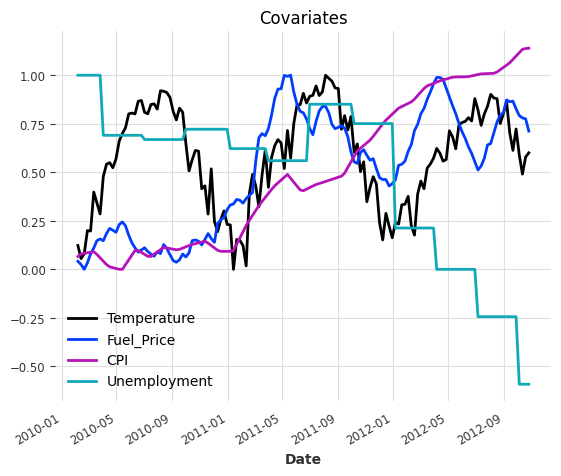

In [ ]:
plt.figure()
all_covariates.plot()
plt.title("Covariates")

In [ ]:
model_nbeats3 = NBEATSModel(
    input_chunk_length=26,
    output_chunk_length=17,
    n_epochs=20,
    random_state=0
)

In [ ]:
model_nbeats3.fit(
    series=training_scaled,
    past_covariates=all_covariates
)

In [ ]:
forecast_nbeats_cov = model_nbeats3.predict(n=17, series=training_scaled, past_covariates=all_covariates)

In [ ]:
pred_cov = model_nbeats3.predict(n=17, series=training_scaled, past_covariates=all_covariates)

training_scaled[['1']].plot(label="actual")
pred_cov[['1']].plot(label="forecast")
plt.legend()

In [ ]:
forecast_nbeats_cov = scaler_dataset.inverse_transform(forecast_nbeats_cov)

In [ ]:
metrics = eval_model(None, training_set_nbeats[['1']], test_set_nbeats[['1']], forecast_nbeats_cov[['1']], 'Multiseries NBeats with covariates')
metric_record.append(metrics)

In [ ]:
preds_nbeats_multi_1_cov_test = [*training_scaled[['1']].values().flatten().tolist(), *forecast_nbeats_cov[['1']].values().flatten().tolist()]
pred_df['nbeats_multi_predictions_cov'] = preds_nbeats_multi_1_cov_test
fig = plot_forecast(pred_df, forecast_columns=["nbeats_multi_predictions_cov"], forecast_display_names=['NBeats Predictions'])
fig.update_xaxes(type="date", range=["2012-07-06", "2012-10-26"])
fig.update_layout(title=dict(text=f"Naive: MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Forecast Bias: {metrics['Forecast Bias']:.4f}"))
fig.show()